<a href="https://colab.research.google.com/github/irenetsk/mastersthesis/blob/main/2_UMAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UMAP (Semi-supervised)
https://umap-learn.readthedocs.io/en/latest/supervised.html?highlight=semi#using-partial-labelling-semi-supervised-umap

In [ ]:
%%capture
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My Drive/
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
import sklearn.metrics as metrics
# from sklearn.semi_supervised import LabelPropagation
# import random
! pip install --upgrade tbb
! pip install umap-learn
import umap
! pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer

## OLD

### Training Set Creation
1 = Enthusiastic / 2 = Neutral / 3 = Sad / 4 = Angry


In [ ]:
# READSPEAKER SENTENCES
angrysents = []
with open("./thesis/readspeaker_annots/emotion_02_anger.txt", encoding='utf-8') as f:
  f = (f.read()).split("\n")
  for sent in f:
    angrysents.append(sent)
# angrysents = list(set(angrysents))                                # to ensure the deletion of duplicates
angrylabels = ['4' for i in range(len(angrysents))]

enthusents = []
with open("./thesis/readspeaker_annots/emotion_03_happy.txt", encoding='utf-8') as f:
  f = (f.read()).split("\n")
  for sent in f:
    enthusents.append(sent)
# enthusents = list(set(enthusents))
enthulabels = ['1' for i in range(len(enthusents))]

sadsents = []
with open("./thesis/readspeaker_annots/emotion_04_sadness.txt", encoding='utf-8') as f:
  f = (f.read()).split("\n")
  for sent in f:
    sadsents.append(sent)
# sadsents = list(set(sadsents))
sadlabels = ['3' for i in range(len(sadsents))]

# MY ANNOTATIONS
trainsents = []
with open("./thesis/myannotations/sents.txt", encoding='utf-8') as f:
  f = (f.read()).split("\n")
  for sent in f:
    trainsents.append(sent)

trainlabels = []
with open("./thesis/myannotations/labels.txt", encoding='utf-8') as f:
  f = (f.read()).split("\n")
  for label in f:
    trainlabels.append(label)

with open("./thesis/myannotations/moreneutral_sents.txt", encoding='utf-8') as f:
  f = (f.read()).split("\n")
  for sent in f:
    trainsents.append(sent)
  for i in range(len(f)):
    trainlabels.append('2')

rs_sents = angrysents + enthusents + sadsents
rs_labels = angrylabels + enthulabels + sadlabels
combinedsents = trainsents + rs_sents
combinedlabels = trainlabels + rs_labels

In [ ]:
# print(f'enthusiastic: \t{len(enthusents)} \nsad: \t\t{len(sadsents)}\nangry: \t\t{len(angrysents)}\nmy annotations: {len(trainsents)}\ntotal: \t\t{sum([len(angrysents), len(enthusents), len(sadsents), len(trainsents)])}')

In [ ]:
X_lab, X_unlab = [],[]
y_lab, y_unlab = [],[]

with open("thesis/corpora/eng-simple_wikipedia_2021_10K-sentences.txt", encoding='utf-8') as f1:
  f1 = (f1.read()).split("\n")
  with open("thesis/corpora/eng-uk_web-public_2018_10K-sentences.txt", encoding='utf-8') as f2:
    f2 = (f2.read()).split("\n")
    for i, line in enumerate(f1+f2):
        sent = (line[(len(str(i+1))):]).strip()                                     # removes the line number and the tab char
        if sent in trainsents:
          X_lab.append(sent)
          y_lab.append(combinedlabels[combinedsents.index(sent)])
        else:
          X_unlab.append(sent)
          y_unlab.append(-1)

for i, sent in enumerate(rs_sents):
  X_lab.append(sent)
  y_lab.append(combinedlabels[combinedsents.index(sent)])

In [ ]:
sbert = SentenceTransformer('paraphrase-MiniLM-L3-v2')
X_lab2 = sbert.encode(X_lab)
X_unlab2 = sbert.encode(X_unlab)

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/69.6M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

### UMAP stuff

In [ ]:
train_data = np.array(X_lab2)
test_data = np.array(X_unlab2)
train_labels = [int(i) for i in y_lab]
classes = ['happy','neutral','sad','angry']
target = np.asarray(train_labels)

#### Standard unsupervised dimension reduction

In [ ]:
embedding = umap.UMAP(n_neighbors=5).fit_transform(train_data)
# mapper = umap.UMAP(n_neighbors=5).fit(train_data, np.array(train_labels))

KeyboardInterrupt: ignored

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, s=1.0, c=target, cmap='Spectral_r', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(5))
cbar.set_ticks(np.arange(5))
cbar.set_ticklabels(classes)
# plt.title('Fashion MNIST Embedded via UMAP');

####Using Labels to Separate Classes 

In [ ]:
embedding = umap.UMAP().fit_transform(train_data, y=target)

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, s=0.5, c=target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(5)-0.5)
cbar.set_ticks(np.arange(4))
cbar.set_ticklabels(classes)
# plt.title('Fashion MNIST Embedded via UMAP using Labels');

#### Using Partial Labelling (Semi-Supervised UMAP)

In [ ]:
masked_target = (target.copy()).astype(np.int8)
masked_target[np.random.choice(2593, size=370, replace=False)] = -1

In [ ]:
fitter = umap.UMAP().fit(train_data, y=masked_target)
embedding = fitter.embedding_

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, s=0.5, c=target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(5)-0.5)
cbar.set_ticks(np.arange(4))
cbar.set_ticklabels(classes)
# plt.title('Fashion MNIST Embedded via UMAP using Partial Labels');

#### Training with Labels and Embedding Unlabelled Test Data (Metric Learning with UMAP)

In [ ]:
mapper = umap.UMAP(n_neighbors=10).fit(train_data, np.array(train_labels))

In [ ]:
%%time
test_embedding = mapper.transform(test_data[:len(train_data)])

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*mapper.embedding_.T, s=0.3, c=np.array(train_labels), cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(5)-0.5)
cbar.set_ticks(np.arange(4))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Train Digits Embedded via UMAP Transform');

In [ ]:
combembed = np.concatenate((mapper.embedding_, test_embedding), axis=0)

In [ ]:
test_labels = [-1 for i in range(len(train_data))]
comblabs = train_labels + test_labels

In [ ]:
import sklearn.metrics as metrics
from sklearn.semi_supervised import LabelPropagation
model = LabelPropagation(kernel = 'rbf', tol = 0.1)   
model.fit(combembed, comblabs)
y_pred = model.predict(X_test)
sc = model.score(X_test, y_test)
print(sc)
print(model.n_iter_)

## NEW TESTS

In [ ]:
# READSPEAKER SENTENCES
angrysents = []
with open("./thesis/readspeaker_annots/emotion_02_anger.txt", encoding='utf-8') as f:
  f = (f.read()).split("\n")
  for sent in f:
    angrysents.append(sent)
angrylabels = [4 for i in range(len(angrysents))]

enthusents = []
with open("./thesis/readspeaker_annots/emotion_03_happy.txt", encoding='utf-8') as f:
  f = (f.read()).split("\n")
  for sent in f:
    enthusents.append(sent)
enthulabels = [1 for i in range(len(enthusents))]

sadsents = []
with open("./thesis/readspeaker_annots/emotion_04_sadness.txt", encoding='utf-8') as f:
  f = (f.read()).split("\n")
  for sent in f:
    sadsents.append(sent)
sadlabels = [3 for i in range(len(sadsents))]

# MY ANNOTATIONS
trainsents = []
with open("./thesis/myannotations/sents.txt", encoding='utf-8') as f:
  f = (f.read()).split("\n")
  for sent in f:
    trainsents.append(sent)

trainlabels = []
with open("./thesis/myannotations/labels.txt", encoding='utf-8') as f:
  f = (f.read()).split("\n")
  for label in f:
    trainlabels.append(label)

with open("./thesis/myannotations/moreneutral_sents.txt", encoding='utf-8') as f:
  f = (f.read()).split("\n")
  for sent in f:
    trainsents.append(sent)
  for i in range(len(f)):
    trainlabels.append('2')
    
comb_sents = trainsents + angrysents + enthusents + sadsents
comb_labels = trainlabels + angrylabels + enthulabels + sadlabels

In [ ]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
embeddings = model.encode(comb_sents)

In [ ]:
X_train_temp = np.array([embeddings[i] for i, sent in enumerate(comb_sents)])
y_train_temp = [int(element) for element in comb_labels]
X_train, X_test, y_train, y_test = train_test_split(X_train_temp, y_train_temp, random_state=42, train_size=0.65)

In [ ]:
train_data = np.array(X_train)
test_data = np.array(X_test)
train_labels = np.array(y_train)
test_labels = np.array(y_test)
classes = ['happy','neutral','sad','angry']

In [ ]:
mapper = umap.UMAP(n_neighbors=10).fit(train_data, np.array(train_labels))

In [ ]:
test_embedding = mapper.transform(test_data)

In [ ]:
# fig, ax = plt.subplots(1, figsize=(14, 10), dpi=100)
# plt.scatter(*mapper.embedding_.T, s=1, c=np.array(train_labels), cmap='Spectral', alpha=1.0)
# plt.setp(ax, xticks=[], yticks=[])
# cbar = plt.colorbar(boundaries=np.arange(5)+0.5)
# cbar.set_ticks(np.arange(5))
# cbar.set_ticklabels(classes)
# # plt.title('Sentence Vectors Embedded via UMAP Transform');

In [ ]:
# fig, ax = plt.subplots(1, figsize=(14, 10), dpi=100)
# plt.scatter(*test_embedding.T, s=2, c=np.array(test_labels), cmap='Spectral', alpha=1.0)
# plt.setp(ax, xticks=[], yticks=[])
# cbar = plt.colorbar(boundaries=np.arange(5)+0.5)
# cbar.set_ticks(np.arange(5))
# cbar.set_ticklabels(classes)
# # plt.title('Fashion MNIST Train Digits Embedded via UMAP');

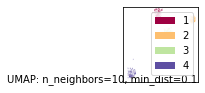

In [ ]:
%%capture
! pip install umap-learn[plot]
import umap.plot
# umap.plot.points(mapper, labels=train_labels, width=100, height=100)

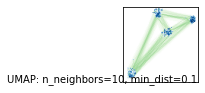

In [ ]:
# umap.plot.connectivity(mapper, show_points=True, edge_cmap=plt.cm.Greens, width=100, height=100)

/usr/local/lib/python3.7/dist-packages/umap/plot.py:886: UserWarning: Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!
  "Hammer edge bundling is expensive for large graphs!\n"


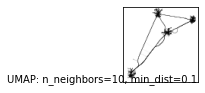

In [ ]:
# umap.plot.connectivity(mapper, edge_bundling='hammer', width=100, height=100)

In [ ]:
mapper.embedding_.shape

(1685, 2)

In [ ]:
test_embedding.shape

(908, 2)

In [ ]:
import sklearn.metrics as metrics
from sklearn.semi_supervised import LabelPropagation
model = LabelPropagation(kernel = 'rbf', gamma=1, tol = 0.1)   
model.fit(mapper.embedding_, y_train)
# y_pred = model.predict(test_embedding)
sc = model.score(test_embedding, y_test)
print(sc)
# print(model.n_iter_)

0.6916299559471366
